In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

keras = tf.keras

In [2]:
def move_datas(dirname):
    new_dir = input("New directory name: ")
    all_class = {'train': {}, 'valid': {}}
    for cl in os.listdir(dirname):
        items = os.listdir(f'{dirname}/{cl}')
        test_count = int(.2*(len(items)))
        all_class['train'][cl] = items[test_count:]
        all_class['valid'][cl] = items[:test_count]

    for category, cl in all_class.items():
        for sub_class, item in cl.items():
            for i in item:
                des_path = f'{new_dir}/{category}/{sub_class}/'
                os.makedirs(des_path, exist_ok=True)
                shutil.copy(f'{dirname}/{sub_class}/{i}', des_path)

In [3]:
def load_data(dirname):
    x_train = []
    y_train = []
    x_test = []
    y_test = []

    for typ in os.listdir(f'{dirname}/'):
        for cls in os.listdir(f'{dirname}/{typ}/'):
            for i in os.listdir(f'{dirname}/{typ}/{cls}/'):
                if typ == 'train':
                    x_train.append(f'{dirname}/train/{cls}/{i}')
                    y_train.append(cls[:-1])
                else:
                    x_test.append(f'{dirname}/valid/{cls}/{i}')
                    y_test.append(cls[:-1])
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [4]:
def create_unique_label(x):
    return np.unique(x)

def processing_label(label):
    label = [i == unique_label for i in label]
    label = np.array(label).astype(int)
    return label

def processing_images(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])
    return image

In [5]:
def pair_datas(image, label):
    return processing_images(image), label

def batch_datas(image, label=None, for_valid=False, for_test=False):
    if for_test:
        datas = tf.data.Dataset.from_tensor_slices((image))
        batch = datas.map(processing_images).batch(32)
    elif for_valid:
        datas = tf.data.Dataset.from_tensor_slices((tf.constant(image), tf.constant(label)))
        batch = datas.map(pair_datas).batch(32)
    else:
        datas = tf.data.Dataset.from_tensor_slices((tf.constant(image), tf.constant(label)))
        datas = datas.shuffle(buffer_size=len(image))
        batch = datas.map(pair_datas).batch(32)
        
    return batch

In [6]:
# Buat model

def create_model(output_layer_activaton, optimizers):
    if optimizers == 'adam':
        optimizers = keras.optimizers.Adam()
    elif optimizers == 'adadelta':
        optimizers = keras.optimizers.Adadelta()
    elif optimizers == 'rmsprop':
        optimizers = keras.optimizers.RMSprop()
    model = keras.Sequential([
        # input layers
        keras.layers.Conv2D(input_shape=(224, 224, 3), filters=32, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(),

        # hidden layers
        keras.layers.Conv2D(input_shape=(224, 224, 3), filters=64, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(input_shape=(224, 224, 3), filters=128, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(128),
        keras.layers.Activation('relu'),

        # output layers
        keras.layers.Dense(2),
        keras.layers.Activation(output_layer_activaton)
    ])
    model.compile(loss='categorical_crossentropy', optimizer=optimizers, metrics=['acc'])
    model_summary = model.summary()
    return model, model_summary

def train_model(model, train_data, valid_data):
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    model_train_history = model.fit(train_data, validation_data=valid_data, validation_freq=1, epochs=50, callbacks=[early_stopping], verbose=1)
    return model_train_history

In [7]:
def plot_history(history):
    plot_title = input("Plot title: ")
    plt.plot(history.history['acc'], label='acc')
    plt.plot(history.history['val_acc'], label='val_acc')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title(plot_title)
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.tight_layout()
    plt.grid(True)
    plt.savefig(f'{plot_title}.jpg')
    plt.show()

In [21]:
def predict(models, tick_labels, to_folder, unseen_image=[]):
    test_data = batch_datas(unseen_image, for_test=True)
    prediction = models.predict(test_data)

    for image, pred in zip(unseen_image, prediction):
        fig, axes = plt.subplots(nrows=1, ncols=2)
        axes[0].imshow(processing_images(image))
        axes[0].axis(False)
        axes[0].set_title('Actual Image')
        
        axes[1].bar([0, 1], pred)
        axes[1].set_xticks([0, 1])
        axes[1].set_xticklabels(tick_labels)
        axes[1].set_title('Prediction Probability')
        plt.savefig(f'output/{to_folder}/prediction_test_{image.split("/")[-1].split(".")[0]}.jpg')
        plt.show()

# Inisialisasikan fungsi

In [9]:
# Memisahkan dataset
move_datas('data')

In [10]:
# Memuat data kedalam variabel
x_train, y_train, x_test, y_test = load_data('dataset-sawi')

In [11]:
x_train, x_test

(array(['dataset-sawi/train/Data Sawi Ada Hama/19.png',
        'dataset-sawi/train/Data Sawi Ada Hama/190.png',
        'dataset-sawi/train/Data Sawi Ada Hama/191.png',
        'dataset-sawi/train/Data Sawi Ada Hama/192.png',
        'dataset-sawi/train/Data Sawi Ada Hama/193.png',
        'dataset-sawi/train/Data Sawi Ada Hama/194.png',
        'dataset-sawi/train/Data Sawi Ada Hama/195.png',
        'dataset-sawi/train/Data Sawi Ada Hama/196.png',
        'dataset-sawi/train/Data Sawi Ada Hama/197.png',
        'dataset-sawi/train/Data Sawi Ada Hama/198.png',
        'dataset-sawi/train/Data Sawi Ada Hama/199.png',
        'dataset-sawi/train/Data Sawi Ada Hama/2.png',
        'dataset-sawi/train/Data Sawi Ada Hama/20.png',
        'dataset-sawi/train/Data Sawi Ada Hama/200.png',
        'dataset-sawi/train/Data Sawi Ada Hama/201.png',
        'dataset-sawi/train/Data Sawi Ada Hama/202.png',
        'dataset-sawi/train/Data Sawi Ada Hama/203.png',
        'dataset-sawi/train/Data Sa

In [12]:
y_train, y_test

(array(['Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
      

In [13]:
unique_label = create_unique_label(y_test)
y_train = processing_label(y_train)
y_test = processing_label(y_test)

train_data = batch_datas(x_train, y_train)
valid_data = batch_datas(x_test, y_test, for_valid=True)

x_train, y_train, x_test, y_test = load_data('dataset-sawi')

In [14]:
x_train, x_test

(array(['dataset-sawi/train/Data Sawi Ada Hama/19.png',
        'dataset-sawi/train/Data Sawi Ada Hama/190.png',
        'dataset-sawi/train/Data Sawi Ada Hama/191.png',
        'dataset-sawi/train/Data Sawi Ada Hama/192.png',
        'dataset-sawi/train/Data Sawi Ada Hama/193.png',
        'dataset-sawi/train/Data Sawi Ada Hama/194.png',
        'dataset-sawi/train/Data Sawi Ada Hama/195.png',
        'dataset-sawi/train/Data Sawi Ada Hama/196.png',
        'dataset-sawi/train/Data Sawi Ada Hama/197.png',
        'dataset-sawi/train/Data Sawi Ada Hama/198.png',
        'dataset-sawi/train/Data Sawi Ada Hama/199.png',
        'dataset-sawi/train/Data Sawi Ada Hama/2.png',
        'dataset-sawi/train/Data Sawi Ada Hama/20.png',
        'dataset-sawi/train/Data Sawi Ada Hama/200.png',
        'dataset-sawi/train/Data Sawi Ada Hama/201.png',
        'dataset-sawi/train/Data Sawi Ada Hama/202.png',
        'dataset-sawi/train/Data Sawi Ada Hama/203.png',
        'dataset-sawi/train/Data Sa

In [15]:
y_train, y_test

(array(['Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
        'Data Sawi Ada Ham', 'Data Sawi Ada Ham', 'Data Sawi Ada Ham',
      

In [16]:
model, model_summary  = create_model('softmax', 'adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [18]:
model_train_history = train_model(model, train_data, valid_data)

Epoch 1/50
25/25 [==============================] - 65s 3s/step - loss: 0.0361 - acc: 0.9875 - val_loss: 0.6261 - val_acc: 0.7688
Epoch 2/50
25/25 [==============================] - 65s 3s/step - loss: 0.0657 - acc: 0.9825 - val_loss: 0.4036 - val_acc: 0.8995
Epoch 3/50
25/25 [==============================] - 67s 3s/step - loss: 0.0248 - acc: 0.9900 - val_loss: 1.5700 - val_acc: 0.7688
Epoch 4/50
25/25 [==============================] - 65s 3s/step - loss: 0.0229 - acc: 0.9912 - val_loss: 0.5418 - val_acc: 0.8945
Epoch 5/50
25/25 [==============================] - 64s 3s/step - loss: 0.0073 - acc: 1.0000 - val_loss: 0.8914 - val_acc: 0.8693


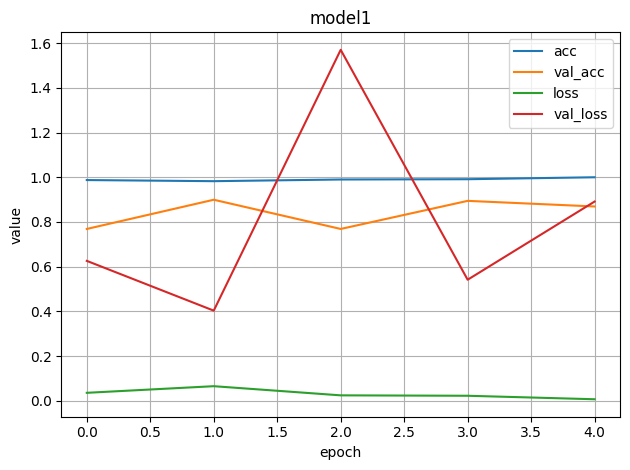

In [19]:
plot_history(model_train_history)

1/1 [==============================] - 0s 240ms/step


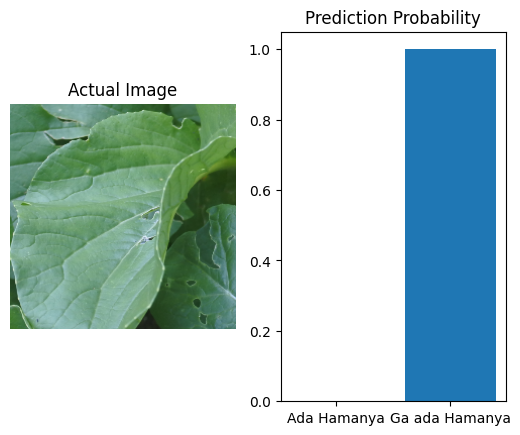

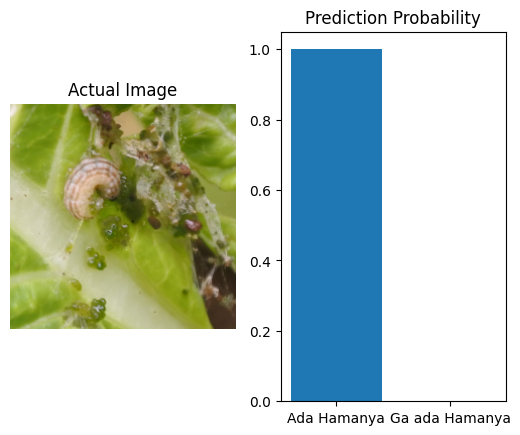

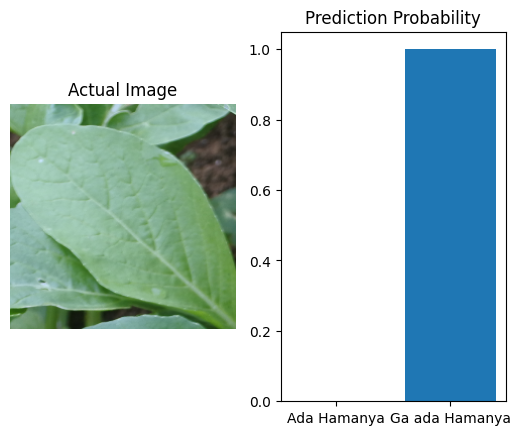

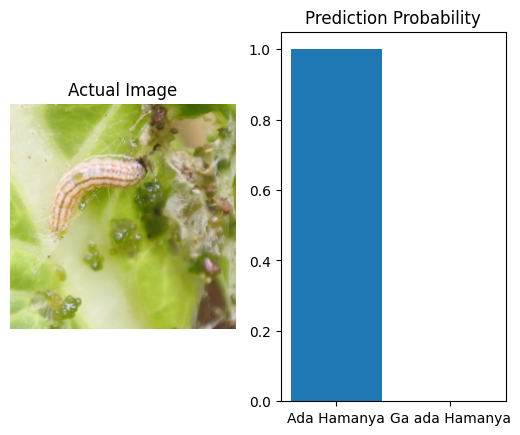

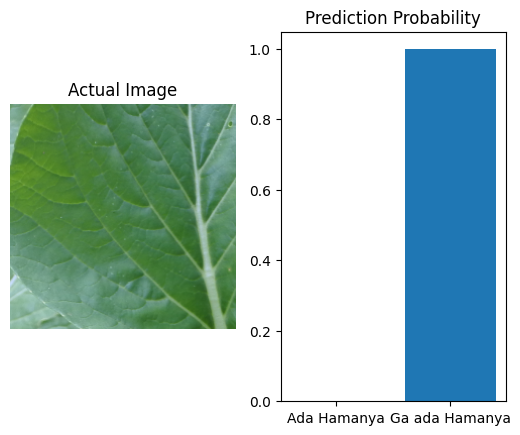

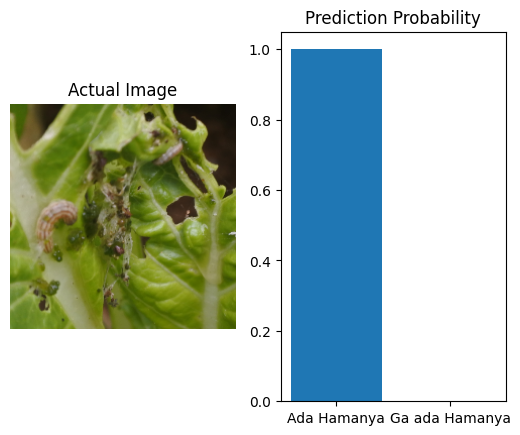

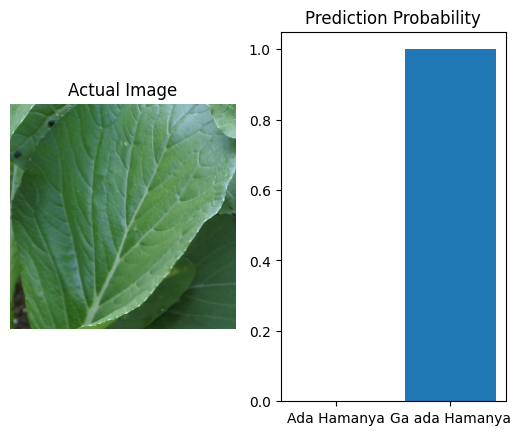

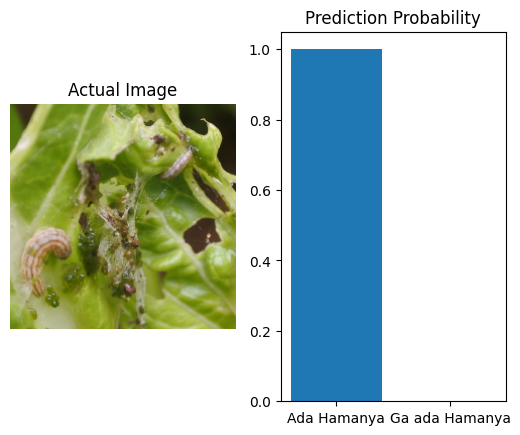

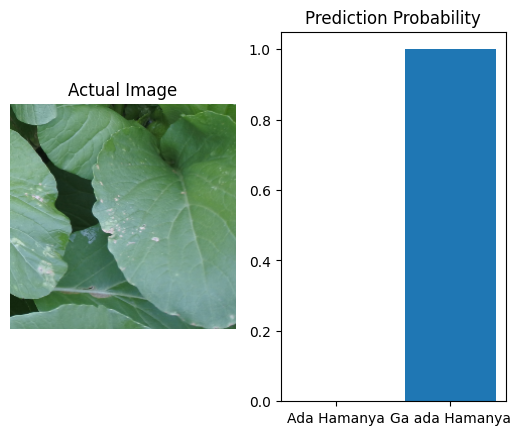

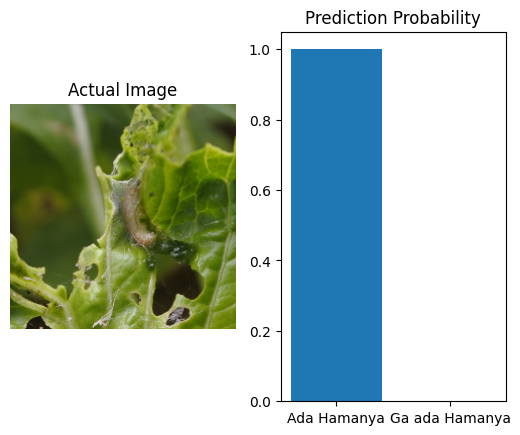

In [22]:
predict(model, ['Ada Hamanya', 'Ga ada Hamanya'], 'model1', list(map(lambda x : f'test/{x}', os.listdir('test'))))